In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Brain_tumor_small/"
IMG_SIZE = 331 
BATCH_SIZE = 32  
EPOCHS = 30
CLASS_NAMES = ['no', 'yes']

In [ ]:
def create_image_dataframe(data_path):
    image_paths = []
    labels = []

    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image_paths.append(img_path)
            labels.append(class_name)

    return pd.DataFrame({'filepath': image_paths, 'label': labels})

df = create_image_dataframe(DATA_PATH)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
def create_datagen(preprocess_input, augmentation=False):
    if augmentation:
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.9, 1.1]
        )
    else:
        return ImageDataGenerator(preprocessing_function=preprocess_input)

preprocess_input = applications.nasnet.preprocess_input

train_datagen = create_datagen(preprocess_input, augmentation=True)
val_datagen = create_datagen(preprocess_input)
test_datagen = create_datagen(preprocess_input)

def create_flow(datagen, dataframe, shuffle=False):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filepath',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=shuffle,
        classes=CLASS_NAMES
    )

train_generator = create_flow(train_datagen, train_df, shuffle=True)
val_generator = create_flow(val_datagen, val_df)
test_generator = create_flow(test_datagen, test_df)


Found 177 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.


In [ ]:
def create_nasnet_model():
    base_model = applications.NASNetLarge(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

model = create_nasnet_model()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_nasnet.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4760 - loss: 0.8948 - precision: 0.5459 - recall: 0.4232

6/6 ━━━━━━━━━━━━━━━━━━━━ 137s 15s/step - accuracy: 0.4814 - loss: 0.8916 - precision: 0.5595 - recall: 0.4288 - val_accuracy: 0.6316 - val_loss: 0.6282 - val_precision: 0.6562 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7657 - loss: 0.5208 - precision: 0.7426 - recall: 0.9686

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7677 - loss: 0.5211 - precision: 0.7434 - recall: 0.9678 - val_accuracy: 0.7105 - val_loss: 0.6195 - val_precision: 0.9333 - val_recall: 0.5833 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8003 - loss: 0.4245 - precision: 0.9069 - recall: 0.7605

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7965 - loss: 0.4291 - precision: 0.9016 - recall: 0.7577 - val_accuracy: 0.7105 - val_loss: 0.5520 - val_precision: 0.7241 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8070 - loss: 0.4346 - precision: 0.7621 - recall: 0.9571

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8095 - loss: 0.4322 - precision: 0.7701 - recall: 0.9513 - val_accuracy: 0.7368 - val_loss: 0.5109 - val_precision: 0.8500 - val_recall: 0.7083 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8653 - loss: 0.3624 - precision: 0.8548 - recall: 0.9021

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8684 - loss: 0.3557 - precision: 0.8634 - recall: 0.9015 - val_accuracy: 0.7632 - val_loss: 0.4438 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8643 - loss: 0.3208 - precision: 0.8750 - recall: 0.9259

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8652 - loss: 0.3193 - precision: 0.8725 - recall: 0.9285 - val_accuracy: 0.8421 - val_loss: 0.4143 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9072 - loss: 0.3059 - precision: 0.9342 - recall: 0.9201 - val_accuracy: 0.7895 - val_loss: 0.4729 - val_precision: 0.9444 - val_recall: 0.7083 - learning_rate: 0.0010
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8955 - loss: 0.2851 - precision: 0.9432 - recall: 0.8869

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8951 - loss: 0.2843 - precision: 0.9416 - recall: 0.8872 - val_accuracy: 0.8684 - val_loss: 0.3612 - val_precision: 0.8800 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9417 - loss: 0.2310 - precision: 0.9373 - recall: 0.9772

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9388 - loss: 0.2315 - precision: 0.9327 - recall: 0.9765 - val_accuracy: 0.7895 - val_loss: 0.3595 - val_precision: 0.8636 - val_recall: 0.7917 - learning_rate: 0.0010
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9022 - loss: 0.2252 - precision: 0.9285 - recall: 0.9069

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9009 - loss: 0.2275 - precision: 0.9315 - recall: 0.9017 - val_accuracy: 0.8421 - val_loss: 0.3509 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9238 - loss: 0.2574 - precision: 0.8983 - recall: 0.9947 - val_accuracy: 0.7632 - val_loss: 0.4519 - val_precision: 0.9412 - val_recall: 0.6667 - learning_rate: 0.0010
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9240 - loss: 0.2239 - precision: 0.9879 - recall: 0.8871

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9252 - loss: 0.2220 - precision: 0.9868 - recall: 0.8900 - val_accuracy: 0.8158 - val_loss: 0.3197 - val_precision: 0.8696 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8900 - loss: 0.2433 - precision: 0.8827 - recall: 0.9536

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8928 - loss: 0.2427 - precision: 0.8847 - recall: 0.9549 - val_accuracy: 0.8947 - val_loss: 0.2900 - val_precision: 0.8846 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9367 - loss: 0.2228 - precision: 0.9419 - recall: 0.9607

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9361 - loss: 0.2217 - precision: 0.9447 - recall: 0.9558 - val_accuracy: 0.8947 - val_loss: 0.2750 - val_precision: 0.9545 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9492 - loss: 0.1539 - precision: 0.9411 - recall: 0.9742 - val_accuracy: 0.8947 - val_loss: 0.2800 - val_precision: 0.9167 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9523 - loss: 0.1384 - precision: 0.9637 - recall: 0.9642 - val_accuracy: 0.8421 - val_loss: 0.3322 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9296 - loss: 0.1613 - precision: 0.9621 - recall: 0.9281 - val_accuracy: 0.8684 - val_loss: 0.2819 - val_precision: 0.9130 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9738 - loss: 0.1110 - precis

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7971 - loss: 0.3949 - precision: 0.8364 - recall: 0.8364

Test Accuracy: 0.7895
Test Loss: 0.3954
Precision: 0.8261
Recall: 0.8261
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 18s/step

Classification Report:
              precision    recall  f1-score   support

          no       0.73      0.73      0.73        15
         yes       0.83      0.83      0.83        23

    accuracy                           0.79        38
   macro avg       0.78      0.78      0.78        38
weighted avg       0.79      0.79      0.79        38



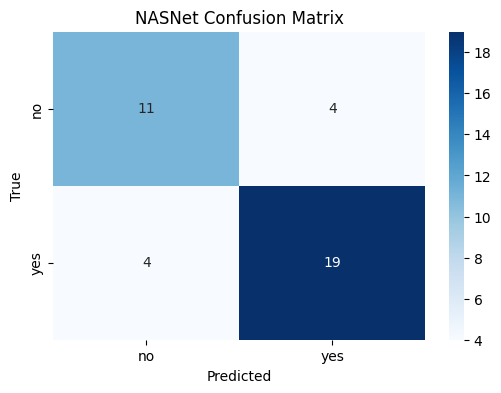

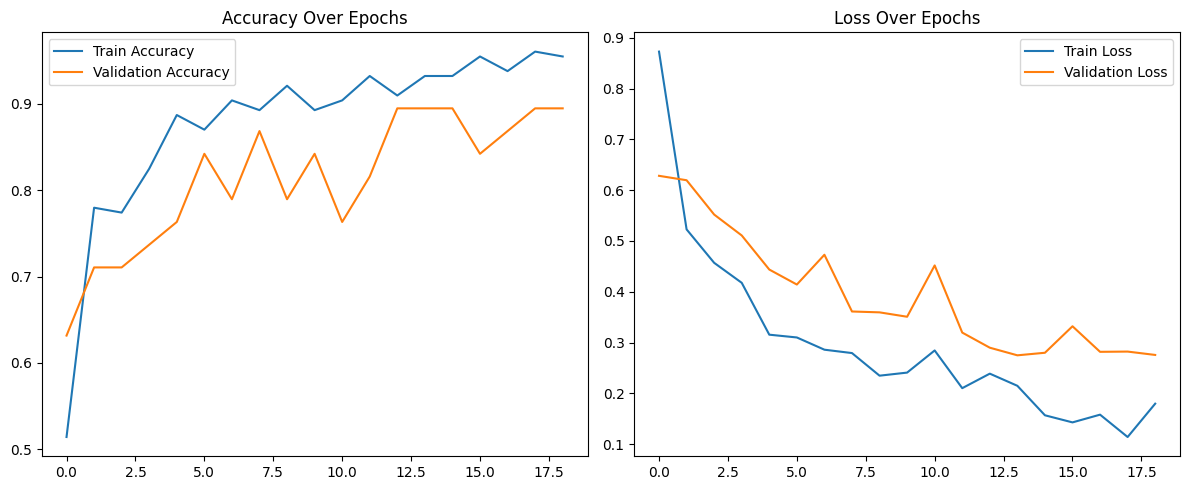

In [ ]:
model.load_weights('best_nasnet.h5')

test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('NASNet Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()